# Лабораторная работа №4
## по предмету "Системы искусственного интеллекта"
### Выполнила студентка группы БВТ2101 Пьянова Анна

Целью работы является введение и знакомство с нейронными сетями.


In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Задание 1

Загрузите набор данных MNIST.
Проверьте баланс классов, нормализуйте данные.

In [2]:
def load_data(data_dir):
    images = []
    labels = []
    for label in range(10):
        label_dir = os.path.join(data_dir, str(label))
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            image = Image.open(file_path).convert('L')
            image = np.array(image)
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_data('data/train')
test_images, test_labels = load_data('data/test')

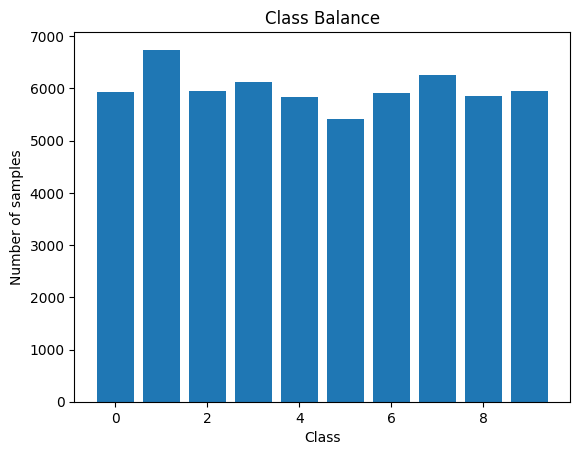

In [3]:
def plot_class_balance(labels):
    counter = Counter(labels)
    plt.bar(counter.keys(), counter.values())
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class Balance')
    plt.show()

plot_class_balance(train_labels)

In [3]:
train_images = train_images.reshape(-1, 28*28)
test_images = test_images.reshape(-1, 28*28)

scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

In [31]:
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((labels.shape[0], num_classes))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot

train_labels_one_hot = one_hot_encode(train_labels)
test_labels_one_hot = one_hot_encode(test_labels)

### Задание 2

Реализуйте однослойный перцептрон с применением алгоритма градиентного спуска для обучения.

In [36]:
class Perceptron:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))

    def forward(self, X):
        return np.dot(X, self.weights) + self.bias

    def backward(self, X, y_true, y_pred, learning_rate):
        error = y_pred - y_true
        dW = np.dot(X.T, error) / X.shape[0]
        db = np.mean(error, axis=0, keepdims=True)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

In [37]:
def train_perceptron(model, X_train, y_train, X_test, y_test, epochs=10, learning_rate=0.01):
    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        model.backward(X_train, y_train, y_pred, learning_rate)

        train_accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1))
        print(f"Epoch {epoch}, Train Accuracy: {train_accuracy:.4f}")

    test_pred = model.predict(X_test)
    test_accuracy = np.mean(test_pred == np.argmax(y_test, axis=1))
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [38]:
input_size = 28 * 28
output_size = 10
model_perceptron = Perceptron(input_size, output_size)
train_perceptron(model_perceptron, train_images, train_labels_one_hot, test_images, test_labels_one_hot)

C:\Users\user\AppData\Local\Temp\ipykernel_14564\2657172677.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(X, self.weights) + self.bias
C:\Users\user\AppData\Local\Temp\ipykernel_14564\2657172677.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dW = np.dot(X.T, error) / X.shape[0]


Epoch 0, Train Accuracy: 0.1153
Epoch 1, Train Accuracy: 0.2193
Epoch 2, Train Accuracy: 0.3106
Epoch 3, Train Accuracy: 0.3881
Epoch 4, Train Accuracy: 0.4520
Epoch 5, Train Accuracy: 0.5029
Epoch 6, Train Accuracy: 0.5445
Epoch 7, Train Accuracy: 0.5770
Epoch 8, Train Accuracy: 0.6034
Epoch 9, Train Accuracy: 0.6250
Test Accuracy: 0.6506


### Задание 3

Изучите документацию библиотеки PyTorch, посмотрите, как создаются сверточные, полносвязные слои и слои пуллинга. Напишите свою нейронную сеть, поэксперементируйте со слоями. Обучите ее на основе набора данных MNIST.

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
model_cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

train_images = train_images.view(-1, 1, 28, 28)
test_images = test_images.view(-1, 1, 28, 28)

In [12]:
num_epochs = 12
for epoch in range(num_epochs):
    model_cnn.train()
    outputs = model_cnn(train_images)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/12], Loss: 2.3019
Epoch [2/12], Loss: 2.1186
Epoch [3/12], Loss: 1.8860
Epoch [4/12], Loss: 1.6483
Epoch [5/12], Loss: 1.4368
Epoch [6/12], Loss: 1.2611
Epoch [7/12], Loss: 1.1122
Epoch [8/12], Loss: 0.9805
Epoch [9/12], Loss: 0.8668
Epoch [10/12], Loss: 0.7766
Epoch [11/12], Loss: 0.7077
Epoch [12/12], Loss: 0.6466


In [13]:
model_cnn.eval()
with torch.no_grad():
    test_outputs = model_cnn(test_images)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == test_labels).sum().item() / test_labels.size(0)
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8408
